In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import aiohttp
import asyncio
import requests
from tqdm.auto import tqdm
from glob import glob

import meerkat as mk

from PIL import Image

In [21]:
mk.gui.start()

Meerkat interactive mode started! API on http://127.0.0.1:7860,         and GUI server on http://localhost:7861.


NetworkInfo(api=<fastapi.applications.FastAPI object at 0x7f25ee6a0d00>, api_server_port=7860, api_server=<meerkat.interactive.server.Server object at 0x7f25af86c7f0>, npm_server_port=7861, npm_process=<Popen: returncode: None args: ['npm', 'run', 'dev', '--', '--port', '7861',...>, api_server_name='127.0.0.1', npm_server_name='localhost', shareable_npm_server_name=None, shareable_api_server_name=None, npm_out_path='/tmp/tmpiv30qouv.out', npm_err_path='/tmp/tmpkovxcq0t.err')

In [3]:
# Load NGOA published images at 224 x 224 (rescaled to fit this size) and CLIP embeddings
clip_dp = mk.DataPanel({'image_path': glob('/data/datasets/opendata/published_images_224/*')})
clip_dp['uuid'] = clip_dp['image_path'].str.split("/").str.get(-1).str.rstrip(".jpg")
clip_dp['image_224'] = mk.ImageColumn.from_filepaths(clip_dp['image_path'])
clip_dp = clip_dp.merge(mk.DataPanel.read('/data/datasets/opendata/ngoa_published_images_224_clip.mk/'), on='uuid')
clip_dp = clip_dp.sort('uuid')

In [4]:
ngoa = mk.get(
    'ngoa',
    '/data/datasets/opendata/',
)
ngoa

/home/karan/meerkat/meerkat/datapanel.py:436: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return cls.from_pandas(pd.read_csv(filepath, *args, **kwargs))


{'objects': DataPanel(nrows: 137923, ncols: 29),
 'published_images': DataPanel(nrows: 104505, ncols: 13),
 'objects_constituents': DataPanel(nrows: 798353, ncols: 12),
 'constituents': DataPanel(nrows: 26102, ncols: 13),
 'constituents_text_entries': DataPanel(nrows: 6894, ncols: 4),
 'locations': DataPanel(nrows: 1083, ncols: 6),
 'objects_text_entries': DataPanel(nrows: 210562, ncols: 4)}

In [5]:
published_images = ngoa['published_images']
objects = ngoa['objects']
objects_constituents = ngoa['objects_constituents']
constituents = ngoa['constituents']
constituents_text_entries = ngoa['constituents_text_entries']
locations = ngoa['locations']
objects_text_entries = ngoa['objects_text_entries']

In [6]:
# Multiple rows in published_images correspond to the same object

In [7]:
objects['objectid'].unique().shape, objects.shape

((137923,), (137923, 29))

In [10]:
# Merge the images and embeddings into the published_images table
published_images = mk.merge(published_images, clip_dp, on="uuid")

In [12]:
# Merge the published_images and objects tables, along with embeddings saved on disk for the text columns in the objects
dp = mk.merge(published_images, objects, left_on='depictstmsobjectid', right_on='objectid')
dp = dp['objectid', 'uuid', 'image_224', 'clip(image_224)', 'title', 'parentid', 'beginyear', 'endyear', 'medium', 'dimensions', 'inscription', 'attribution', 'creditline', 'visualbrowserclassification']

(104495, 14)

In [13]:
dp = dp.merge(
    mk.DataPanel.read(
        '/data/datasets/opendata/ngoa_objects_images_clip_embs.mk/', 
    ),
    on='objectid'
)

,objectid (PandasSeriesColumn),uuid (PandasSeriesColumn),image_224 (ImageColumn),clip(image_224) (NumpyArrayColumn),title (PandasSeriesColumn),parentid (PandasSeriesColumn),beginyear (PandasSeriesColumn),endyear (PandasSeriesColumn),medium (PandasSeriesColumn),dimensions (PandasSeriesColumn),inscription (PandasSeriesColumn),attribution (PandasSeriesColumn),creditline (PandasSeriesColumn),visualbrowserclassification (PandasSeriesColumn),clip(medium) (NumpyArrayColumn),clip(dimensions) (NumpyArrayColumn),clip(inscription) (NumpyArrayColumn),clip(attribution) (NumpyArrayColumn),clip(creditline) (NumpyArrayColumn),clip(title) (NumpyArrayColumn),_match_image_224_king (NumpyArrayColumn),_match_image_224_a king in court (NumpyArrayColumn),_match_image_224_royalty (NumpyArrayColumn),_match_image_224_an aristocrat (NumpyArrayColumn)
0,143346,953ed257-6e68-4bfd-88b2-528e872348bf,,"np.ndarray(shape=(512,))",Shorty George,NaN,1943.0,1943.0,lithograph,Image: 225 x 145 mm\r\nSheet: 260 x 203 mm,"Inscribed: Within the print: lower right, NL; in pencil: lower left, ""Shorty George"" (within quotes) 4/14; bottom right Norman Lewis 11/20/43\r\n",Norman Lewis,"Reba and Dave Williams Collection, Florian Carr Fund and Gift of the Print Research Foundation",print,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",27.546875,25.890625,23.890625,30.28125

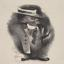

In [37]:
dp.head(1)

In [16]:
# # Code for embedding the text columns in the objects table
# dp['medium'] = dp['medium'].astype('str')
# mk.embed(dp, 'medium')
# dp['dimensions'] = dp['dimensions'].astype('str')
# mk.embed(dp, 'dimensions')
# dp['inscription'] = dp['inscription'].astype('str')
# mk.embed(dp, 'inscription')
# dp['attribution'] = dp['attribution'].astype('str')
# mk.embed(dp, 'attribution')
# dp['creditline'] = dp['creditline'].astype('str')
# mk.embed(dp, 'creditline')
# dp['title'] = dp['title'].astype('str')
# mk.embed(dp, 'title')

In [18]:
# # Writing the embeddings to disk
# dp_temp = dp['objectid', 
#    'medium', 'dimensions', 'inscription', 'attribution', 'creditline', 'title',
#    'clip(medium)', 'clip(dimensions)', 'clip(inscription)', 'clip(attribution)', 'clip(creditline)', 'clip(title)']

# dp_temp['objectid', 'clip(medium)', 'clip(dimensions)', 'clip(inscription)', 'clip(attribution)', 'clip(creditline)', 'clip(title)'].write('/data/datasets/opendata/ngoa_objects_images_clip_embs.mk/')

In [21]:
# Reading the embeddings from disk
# mk.DataPanel.read('/data/datasets/opendata/ngoa_objects_images_clip_embs.mk/')

In [17]:
dp.groupby('creditline')['uuid'].count().sort(by='uuid', ascending=False).head(20)

,uuid (NumpyArrayColumn),creditline (PandasSeriesColumn)
0,18200,Index of American Design
1,17402,Rosenwald Collection
2,5295,Samuel H. Kress Collection
3,4465,Ailsa Mellon Bruce Fund
4,4328,"Reba and Dave Williams Collection, Gift of Reba and Dave Williams"
...,...,...
15,1163,Corcoran Collection (Gift of Dr. Armand Hammer)
16,1045,"Gift of The Mark Rothko Foundation, Inc."
17,1024,Gift of Charles Isaacs and Gregory Leroy
18,1019,Gift of Dorothy J. and Benjamin B. Smith


In [18]:
dp.groupby(by='beginyear')['uuid'].count().sort(by='uuid', ascending=False).head(20)

,uuid (NumpyArrayColumn),beginyear (NumpyArrayColumn)
0,5054,1936.0
1,4496,1935.0
2,4010,1937.0
3,3467,1796.0
4,2837,1938.0
...,...,...
15,922,1884.0
16,853,1967.0
17,828,1903.0
18,817,1977.0


In [19]:
dp.groupby('attribution')['uuid'].count().sort(by='uuid', ascending=False).head(50)

,uuid (NumpyArrayColumn),attribution (PandasSeriesColumn)
0,3364,"Various Artists, including William Blake, after John Gabriel Stedman"
1,2342,Honoré Daumier
2,1698,Carrie Mae Weems
3,1672,Jasper Johns
4,1613,Alfred Stieglitz
...,...,...
45,269,Pierre Bonnard
46,269,Sir Muirhead Bone
47,262,Marc Chagall
48,257,Susan Meiselas


In [20]:
dp.groupby('visualbrowserclassification')['uuid'].count().sort(by='uuid', ascending=False).head(50)

,uuid (NumpyArrayColumn),visualbrowserclassification (PandasSeriesColumn)
0,46249,print
1,32304,drawing
2,15440,photograph
3,13798,sculpture
4,7962,volume
5,3830,painting
6,1632,decorative art
7,1554,portfolio
8,69,technical material
9,5,new media


In [23]:
def match_and_sort(dp, query, input):
    return mk.match(dp, query, input).sort(f'_match_{input}_{query}', ascending=False)

In [31]:
dp = match_and_sort(dp, "A selfie", "image_224")

In [20]:
dp.gui.gallery('image_224', tag_columns=['inscription'])

,objectid (PandasSeriesColumn),uuid (PandasSeriesColumn),image_224 (ImageColumn),clip(image_224) (NumpyArrayColumn),parentid (PandasSeriesColumn),beginyear (PandasSeriesColumn),endyear (PandasSeriesColumn),medium (PandasSeriesColumn),dimensions (PandasSeriesColumn),inscription (PandasSeriesColumn),attribution (PandasSeriesColumn),creditline (PandasSeriesColumn),visualbrowserclassification (PandasSeriesColumn),clip(medium) (NumpyArrayColumn),clip(dimensions) (NumpyArrayColumn),clip(inscription) (NumpyArrayColumn),clip(attribution) (NumpyArrayColumn),clip(creditline) (NumpyArrayColumn),_match_image_224_A selfie (NumpyArrayColumn)
0,71457,0003d4e4-d7fd-4835-8d27-1e9e20672e39,,"np.ndarray(shape=(512,))",NaN,1989.0,1989.0,bronze,overall: 165.1 x 195.6 x 158.7 cm (65 x 77 x 62 1/2 in.) gross weight: 400 lb.,NaN,Joel Shapiro,Gift of the Collectors Committee,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",19.28125
1,41526,0009af76-adc6-4656-aaf8-3c63e51c5085,,"np.ndarray(shape=(512,))",NaN,1832.0,1835.0,bronze,overall: 14.6 x 13 x 9.8 cm (5 3/4 x 5 1/8 x 3 7/8 in.),"stamped in wax positive on rear lower center, in incised circle: M.L.G [Maurice Le Garrec]; cold-stamped below that: BRONZE; cold-stamped inside, front right, in incised circle: 23/25",Honoré Daumier,Rosenwald Collection,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",21.125
2,41526,0009af76-adc6-4656-aaf8-3c63e51c5085,,"np.ndarray(shape=(512,))",NaN,1832.0,1835.0,bronze,overall: 14.6 x 13 x 9.8 cm (5 3/4 x 5 1/8 x 3 7/8 in.),"stamped in wax positive on rear lower center, in incised circle: M.L.G [Maurice Le Garrec]; cold-stamped below that: BRONZE; cold-stamped inside, front right, in incised circle: 23/25",Honoré Daumier,Rosenwald Collection,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",21.125
3,41526,6a8fa1ff-5dc0-4149-8a55-5a8bc22881fc,,"np.ndarray(shape=(512,))",NaN,1832.0,1835.0,bronze,overall: 14.6 x 13 x 9.8 cm (5 3/4 x 5 1/8 x 3 7/8 in.),"stamped in wax positive on rear lower center, in incised circle: M.L.G [Maurice Le Garrec]; cold-stamped below that: BRONZE; cold-stamped inside, front right, in incised circle: 23/25",Honoré Daumier,Rosenwald Collection,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",20.1875
4,41526,6a8fa1ff-5dc0-4149-8a55-5a8bc22881fc,,"np.ndarray(shape=(512,))",NaN,1832.0,1835.0,bronze,overall: 14.6 x 13 x 9.8 cm (5 3/4 x 5 1/8 x 3 7/8 in.),"stamped in wax positive on rear lower center, in incised circle: M.L.G [Maurice Le Garrec]; cold-stamped below that: BRONZE; cold-stamped inside, front right, in incised circle: 23/25",Honoré Daumier,Rosenwald Collection,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",20.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13793,103291,ff827978-3806-47ad-b0e7-fcb1a55a44e5,,"np.ndarray(shape=(512,))",103290.0,1612.0,1612.0,bronze,overall (diameter): 6.4 cm (2 1/2 in.)\r\ngross weight: 41.17 gr (0.091 lb.)\r\naxis: 12:00,across center: .D.M. / PAVLO V.P.M.FAVENTE / AD AMPLIANDAM AEDEM / S.CAROLI NOMINE / ROMAE PRIMO DEDICATAM / LAPIDEM FVNDAMETALEM / PER ARCHIP.S.PETRI / CLERICI RECVLS.PAVLI / PONI CVRARVNT / ANNO MDCXII,Probably Roman 17th Century,Gift of Lisa and Leonard Baskin,sculpture,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",20.25
13794,45066,ff85ba32-f8ae-43d7-bdf5-e23983f8b867,,"np.ndarray(shape=(512,))",NaN,1538.0,1538.0,bronze//Struck,overall (diameter): 4.06 cm (1 5/8 in.)\r\ngross weight: 26.92 g
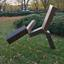
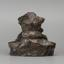
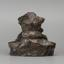
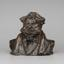
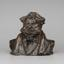
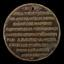
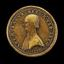
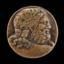
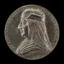
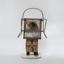

In [32]:
dp[dp['visualbrowserclassification'] == 'sculpture']

In [35]:
cb = dp.clusterby('image_224', )

In [61]:
# dp = match_and_sort(dp, 'Honoré Daumier', 'image_224')
dp = match_and_sort(dp, 'Carrie Mae Weems', 'image_224')

In [33]:
dp = match_and_sort(dp, 'an aristocrat', 'image_224')

In [34]:
# temp = dp[dp['attribution'] != 'Honoré Daumier']['image_224', 'attribution']
# temp = dp[dp['attribution'] != 'Carrie Mae Weems']['image_224', 'attribution']
temp = dp['image_224', 'attribution']

In [35]:
temp.gui.gallery('image_224', ['attribution'])